# This section and all following sections were completed by [Yizhen Peng].

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score, recall_score, f1_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc

# Exploratory Analysis

In [2]:
# Read training dataset
train_data = pd.read_csv('training_set_features.csv')
missing_train_data = train_data.isnull().mean()
missing_train_data = missing_train_data.sort_values(ascending=False)
train_data.describe()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children
count,26707.000000,26615.000000,26591.000000,26636.000000,26499.000000,26688.000000,26665.000000,26620.00000,26625.000000,26579.000000,...,25903.000000,14433.00000,26316.000000,26319.000000,26312.000000,26245.000000,26193.000000,26170.000000,26458.000000,26458.000000
mean,13353.000000,1.618486,1.262532,0.048844,0.725612,0.068982,0.825614,0.35864,0.337315,0.677264,...,0.111918,0.87972,3.850623,2.342566,2.357670,4.025986,2.719162,2.118112,0.886499,0.534583
std,7709.791156,0.910311,0.618149,0.215545,0.446214,0.253429,0.379448,0.47961,0.472802,0.467531,...,0.315271,0.32530,1.007436,1.285539,1.362766,1.086565,1.385055,1.332950,0.753422,0.928173
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,6676.500000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,...,0.000000,1.00000,3.000000,1.000000,1.000000,4.000000,2.000000,1.000000,0.000000,0.000000
50%,13353.000000,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,0.000000,1.000000,...,0.000000,1.00000,4.000000,2.000000,2.000000,4.000000,2.000000,2.000000,1.000000,0.000000
75%,20029.500000,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.00000,1.000000,1.000000,...,0.000000,1.00000,5.000000,4.000000,4.000000,5.000000,4.000000,4.000000,1.000000,1.000000
max,26706.000000,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,...,1.000000,1.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,3.000000


In [3]:
train_labels = pd.read_csv('training_set_labels.csv')
h1n1_vaccine = train_labels.value_counts('h1n1_vaccine')
seasonal_vaccine = train_labels.value_counts('seasonal_vaccine')
print(h1n1_vaccine)
print(seasonal_vaccine)

h1n1_vaccine
0    21033
1     5674
dtype: int64
seasonal_vaccine
0    14272
1    12435
dtype: int64


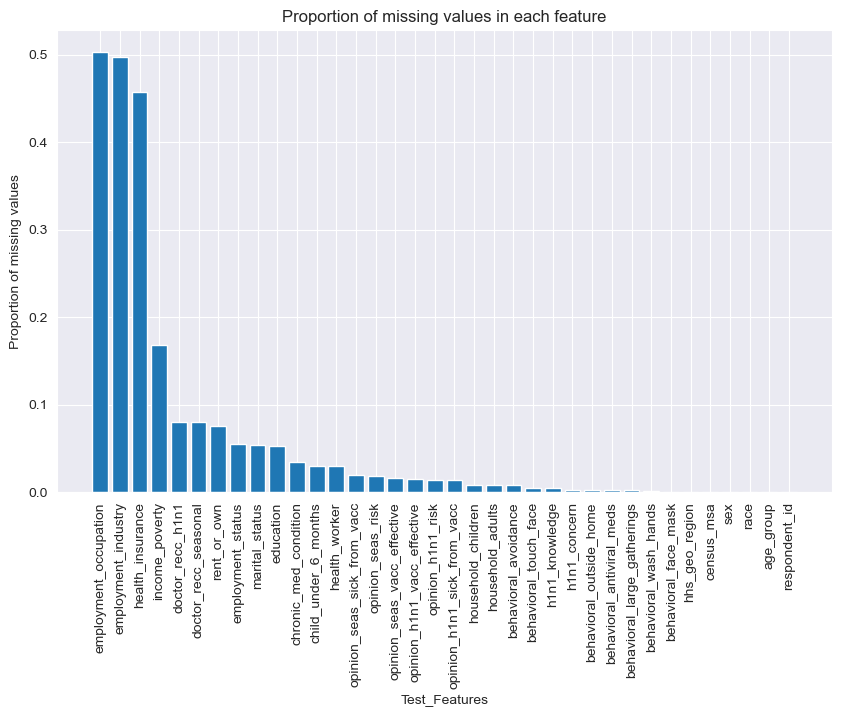

In [4]:
# Read the test dataset
test_data = pd.read_csv('test_set_features.csv')
missing_test_data = test_data.isnull().mean()
missing_test_data = missing_test_data.sort_values(ascending=False)

plt.figure(figsize=(10,6))
plt.xticks(rotation=90)
plt.title('Proportion of missing values in each feature')
plt.xlabel('Test_Features')
plt.ylabel('Proportion of missing values')
plt.bar(missing_test_data.index, missing_test_data.values)
plt.show()

 # Data Processing
 In this part, we will preprocess the training set and test set data, including cleaning the data, filling missing values, and normalizing the data.

In [5]:
# Training dataset processing

# Load data
train_data = pd.read_csv('training_set_features.csv')
train_labels = pd.read_csv('training_set_labels.csv')

# Missing value handling
# Fill missing values
train_data['health_insurance'] = train_data['health_insurance'].fillna('Unknown')
# train_data['employment_industry'] = train_data['employment_industry'].fillna('Unknown')
# train_data['employment_occupation'] = train_data['employment_occupation'].fillna('Unknown')
train_data = train_data.drop(['employment_industry','employment_occupation'], axis=1)
train_data['income_poverty'] = train_data['income_poverty'].replace({
    'Below Poverty': 1,
    '<= $75,000, Above Poverty': 2,
    '> $75,000': 3
})
median_income = train_data['income_poverty'].median()
train_data['income_poverty'] = train_data['income_poverty'].fillna(median_income)
train_data['doctor_recc_seasonal'].fillna(train_data['doctor_recc_seasonal'].mode()[0], inplace=True)
train_data['doctor_recc_h1n1'].fillna(train_data['doctor_recc_h1n1'].mode()[0], inplace=True)
freq = train_data['rent_or_own'].value_counts()
most_common = freq.index[0]
train_data['rent_or_own'].fillna(most_common, inplace=True)
freq1 = train_data['employment_status'].value_counts()
most_common1 = freq1.index[0]
train_data['employment_status'].fillna(most_common1, inplace=True)
str_features = ['marital_status', 'education', 'chronic_med_condition', 'child_under_6_months', 'health_worker',
                'opinion_seas_sick_from_vacc', 'opinion_seas_risk', 'opinion_seas_vacc_effective',
                'opinion_h1n1_sick_from_vacc', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'household_children',
                'household_adults', 'behavioral_touch_face', 'h1n1_knowledge']
for feature in str_features:
    mode_val = train_data[feature].mode()[0]
    train_data[feature] = train_data[feature].fillna(mode_val)

# Delete rows with missing values
drop_features = ['h1n1_concern', 'behavioral_large_gatherings', 'behavioral_outside_home', 'behavioral_antiviral_meds',
                 'behavioral_antiviral_meds', 'behavioral_face_mask', 'behavioral_avoidance', 'behavioral_wash_hands']
train_data = train_data.dropna(subset=drop_features)

# One-hot
# cat_columns = ['health_insurance', 'age_group', 'education', 'race', 'sex', 'marital_status', 'employment_status',
#                'rent_or_own', 'census_msa', 'hhs_geo_region','employment_industry','employment_occupation']

# Drop employment_industry ,employment_occupation
cat_columns = ['health_insurance', 'age_group', 'education', 'race', 'sex', 'marital_status', 'employment_status',
               'rent_or_own', 'census_msa', 'hhs_geo_region']

onehot_train_data = pd.get_dummies(train_data[cat_columns])
new_train_features = pd.concat([train_data.drop(cat_columns, axis=1), onehot_train_data], axis=1)

new_train_all_data = new_train_features.merge(train_labels, on='respondent_id')
train_features = new_train_all_data.drop(['h1n1_vaccine', 'seasonal_vaccine'], axis=1)
train_labels = new_train_all_data[['respondent_id','h1n1_vaccine', 'seasonal_vaccine']]


In [6]:
# Test dataset processing
test_data =pd.read_csv('test_set_features.csv')

# Missing value handling
# Fill missing values
test_data['health_insurance'] = test_data['health_insurance'].fillna('Unknown')
# test_data['employment_industry'] = test_data['employment_industry'].fillna('Unknown')
# test_data['employment_occupation'] = test_data['employment_occupation'].fillna('Unknown')

test_data = test_data.drop(['employment_industry','employment_occupation'], axis=1)
test_data['income_poverty'] = test_data['income_poverty'].replace({
    'Below Poverty': 1,
    '<= $75,000, Above Poverty': 2,
    '> $75,000': 3
})
median_income = test_data['income_poverty'].median()
test_data['income_poverty'] = test_data['income_poverty'].fillna(median_income)
test_data['doctor_recc_seasonal'].fillna(test_data['doctor_recc_seasonal'].mode()[0], inplace=True)
test_data['doctor_recc_h1n1'].fillna(test_data['doctor_recc_h1n1'].mode()[0], inplace=True)
freq = test_data['rent_or_own'].value_counts()
most_common = freq.index[0]
test_data['rent_or_own'].fillna(most_common, inplace=True)
freq1 = test_data['employment_status'].value_counts()
most_common1 = freq1.index[0]
test_data['employment_status'].fillna(most_common1, inplace=True)
# str_features = ['marital_status', 'education', 'chronic_med_condition', 'child_under_6_months', 'health_worker',
#                 'opinion_seas_sick_from_vacc', 'opinion_seas_risk', 'opinion_seas_vacc_effective',
#                 'opinion_h1n1_sick_from_vacc', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'household_children',
#                 'household_adults', 'behavioral_touch_face', 'h1n1_knowledge','employment_industry','employment_occupation',
#                 'h1n1_concern', 'behavioral_large_gatherings', 'behavioral_outside_home', 'behavioral_antiviral_meds',
#                 'behavioral_antiviral_meds', 'behavioral_face_mask', 'behavioral_avoidance', 'behavioral_wash_hands'
#                 ]

# Drop employment_industry ,employment_occupation
str_features = ['marital_status', 'education', 'chronic_med_condition', 'child_under_6_months', 'health_worker',
                'opinion_seas_sick_from_vacc', 'opinion_seas_risk', 'opinion_seas_vacc_effective',
                'opinion_h1n1_sick_from_vacc', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'household_children',
                'household_adults', 'behavioral_touch_face', 'h1n1_knowledge',
                'h1n1_concern', 'behavioral_large_gatherings', 'behavioral_outside_home', 'behavioral_antiviral_meds',
                'behavioral_antiviral_meds', 'behavioral_face_mask', 'behavioral_avoidance', 'behavioral_wash_hands'
                ]
for feature in str_features:
    mode_val = test_data[feature].mode()[0]
    test_data[feature] = test_data[feature].fillna(mode_val)

# One-hot
# cat_columns = ['health_insurance', 'age_group', 'education', 'race', 'sex', 'marital_status', 'employment_status',
#                'rent_or_own', 'census_msa', 'hhs_geo_region','employment_industry','employment_occupation']

cat_columns = ['health_insurance', 'age_group', 'education', 'race', 'sex', 'marital_status', 'employment_status',
               'rent_or_own', 'census_msa', 'hhs_geo_region']
onehot_test_data = pd.get_dummies(test_data[cat_columns])
new_test_data = pd.concat([test_data.drop(cat_columns, axis=1), onehot_test_data], axis=1)


# Normalization

In [7]:
#Train data
# Create a normalizer
scaler = StandardScaler()
features_to_scale = train_features.drop('respondent_id', axis=1).columns

# Fit and normalize transformation on training data
train_features_scaled = train_features.copy()
train_features_scaled[features_to_scale] = scaler.fit_transform(train_features[features_to_scale])
train_features_scaled = train_features_scaled.drop('respondent_id', axis=1)

# Replace old training data with new normalized training data
train_features = train_features_scaled

In [8]:
#Test data
# Create a normalizer
scaler = StandardScaler()
features_to_scale = new_test_data.drop('respondent_id', axis=1).columns

# Fit and normalize transformation on test data
scaler.fit(train_features[features_to_scale])
new_test_data_scaled = new_test_data.copy()
new_test_data_scaled[features_to_scale] = scaler.transform(new_test_data[features_to_scale])
new_test_data_scaled = new_test_data_scaled.drop('respondent_id', axis=1)

# Replace old training data with new normalized training data
new_test_data = new_test_data_scaled


# Data imbalance handling - undersampling
In this section, we undersample the dataset to address the data imbalance. Data imbalance means that in our dataset, the difference in the number of samples between the two categories of `h1n1_vaccine` is too large.  Our goal is to close this gap through undersampling. Specifically, we will reduce the number of samples where `h1n1_vaccine` is 0 to the same number of samples where `h1n1_vaccine` is 1.


In [9]:

def undersample_data(X, y):
    # Combine features and label
    data = pd.concat([X, y], axis=1)

    # Split data based on label
    class_0 = data[y['h1n1_vaccine'] == 0]
    class_1 = data[y['h1n1_vaccine'] == 1]

    # Perform undersampling
    class_0_undersampled = resample(class_0, replace=False, n_samples=len(class_1))

    # Concatenate undersampled class_0 and class_1
    undersampled_data = pd.concat([class_0_undersampled, class_1])

    # Shuffle data
    undersampled_data = undersampled_data.sample(frac=1, random_state=42)

    # Split undersampled_data back into features and label
    X_undersampled = undersampled_data.drop(['respondent_id', 'h1n1_vaccine'], axis=1)
    y_undersampled = undersampled_data[['respondent_id', 'h1n1_vaccine']]

    return X_undersampled, y_undersampled

# Train and evaluate random forest model
 In this part, we will use a random forest model for training and prediction. We will train and predict for two labels `h1n1_vaccine` and `seasonal_vaccine` respectively.

H1N1 Vaccine Accuracy: 0.7714
H1N1 Vaccine Recall: 0.7451
H1N1 Vaccine F1 Score: 0.7653
Seasonal Vaccine Accuracy: 0.7841
Seasonal Vaccine Recall: 0.7558
Seasonal Vaccine F1 Score: 0.7603


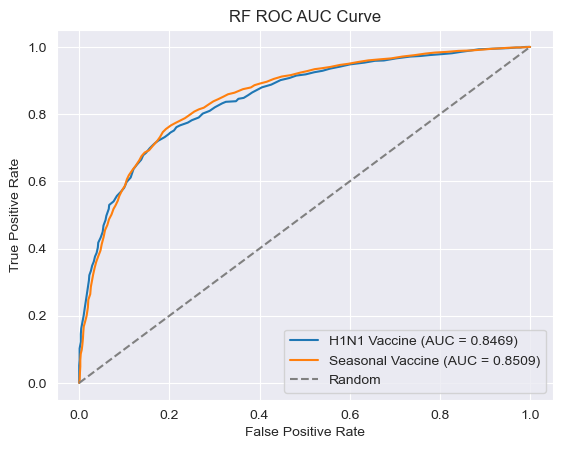

In [10]:
# Random Forest without parameters
y_h1n1 = train_labels[['respondent_id', 'h1n1_vaccine']]
train_features_undersampled, y_h1n1_undersampled = undersample_data(train_features, y_h1n1)

# Split into training and validation sets
X_train_h1n1, X_val_h1n1, y_train_h1n1, y_val_h1n1 = train_test_split(train_features_undersampled, y_h1n1_undersampled['h1n1_vaccine'], test_size=0.2, random_state=42)

# Train the model
tree_h1n1 = RandomForestClassifier()
tree_h1n1.fit(X_train_h1n1, y_train_h1n1)

# Predict probabilities and compute ROC and AUC
y_h1n1_predict = tree_h1n1.predict_proba(X_val_h1n1)[:,1]
fpr1, tpr1, _ = roc_curve(y_val_h1n1, y_h1n1_predict)
auc1 = roc_auc_score(y_val_h1n1, y_h1n1_predict)

# 'seasonal_vaccine' training
y_seasonal = train_labels['seasonal_vaccine']
X_train_seasonal, X_val_seasonal, y_train_seasonal, y_val_seasonal = train_test_split(train_features, y_seasonal, test_size=0.2, random_state=42)

# Train the model
tree_seasonal = RandomForestClassifier()
tree_seasonal.fit(X_train_seasonal, y_train_seasonal)

# Predict probabilities and compute ROC and AUC
y_seasonal_predict = tree_seasonal.predict_proba(X_val_seasonal)[:,1]
fpr2, tpr2, _ = roc_curve(y_val_seasonal, y_seasonal_predict)
auc2 = roc_auc_score(y_val_seasonal, y_seasonal_predict)

y_h1n1_pred = tree_h1n1.predict(X_val_h1n1)
accuracy_h1n1 = accuracy_score(y_val_h1n1, y_h1n1_pred)
print(f'H1N1 Vaccine Accuracy: {accuracy_h1n1:.4f}')
recall_h1n1 = recall_score(y_val_h1n1, y_h1n1_pred)
print(f'H1N1 Vaccine Recall: {recall_h1n1:.4f}')
f1_h1n1 = f1_score(y_val_h1n1, y_h1n1_pred)
print(f'H1N1 Vaccine F1 Score: {f1_h1n1:.4f}')

y_seasonal_pred = tree_seasonal.predict(X_val_seasonal)
accuracy_seasonal = accuracy_score(y_val_seasonal, y_seasonal_pred)
print(f'Seasonal Vaccine Accuracy: {accuracy_seasonal:.4f}')
recall_seasonal = recall_score(y_val_seasonal, y_seasonal_pred)
print(f'Seasonal Vaccine Recall: {recall_seasonal:.4f}')
f1_seasonal = f1_score(y_val_seasonal, y_seasonal_pred)
print(f'Seasonal Vaccine F1 Score: {f1_seasonal:.4f}')

# Draw the ROC curve
plt.figure()
plt.plot(fpr1, tpr1, label=f'H1N1 Vaccine (AUC = {auc1:.4f})')
plt.plot(fpr2, tpr2, label=f'Seasonal Vaccine (AUC = {auc2:.4f})')
plt.plot([0, 1], [0, 1], '--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RF ROC AUC Curve')
plt.legend(loc='lower right')
plt.show()


# GridSearch
In this part, we will tune the hyperparameters of the random forest model and LogisticRegression. We will use the GridSearchCV method to find the best combination of hyperparameters

In [11]:
# Define the parameter combinations to try
param_grid = {
    'max_depth': [10, 15, 20],
    'min_samples_leaf': [1, 2, 3],
    'n_estimators': [100, 200, 300]
}

# Initialize the GridSearchCV object with random_state set
grid_h1n1 = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1)
grid_seasonal = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1)

grid_h1n1.fit(X_train_h1n1, y_train_h1n1)
grid_seasonal.fit(X_train_seasonal, y_train_seasonal)

# Output the best parameters
print("Best parameters RF for h1n1 data: ", grid_h1n1.best_params_)
print("Best parameters RF for seasonal data: ", grid_seasonal.best_params_)

Best parameters RF for h1n1 data:  {'max_depth': 15, 'min_samples_leaf': 2, 'n_estimators': 100}
Best parameters RF for seasonal data:  {'max_depth': 20, 'min_samples_leaf': 3, 'n_estimators': 300}


In [12]:
# Define the parameter combinations to try
param_grid = {
    'C': [0.1, 1.0, 10.0],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

grid_h1n1 = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, n_jobs=-1)
grid_seasonal = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, n_jobs=-1)

# Grid search on the training data
grid_h1n1.fit(X_train_h1n1, y_train_h1n1)
grid_seasonal.fit(X_train_seasonal, y_train_seasonal)

# Output the best parameters
print("Best parameters LG for h1n1 data:", grid_h1n1.best_params_)
print("Best parameters LG for seasonal data:", grid_seasonal.best_params_)

/Users/easonpeng/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/easonpeng/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/easonpeng/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/easonpeng/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/easonpeng/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/easonpeng/anaconda3/lib/python3.10/sit

Best parameters LG for h1n1 data: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best parameters LG for seasonal data: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


# Random Forest with parameters
This part we use the parameters given by grid search for random forest model training

H1N1 Vaccine Accuracy: 0.7822
H1N1 Vaccine Recall: 0.7513
H1N1 Vaccine F1 Score: 0.7754
Seasonal Vaccine Accuracy: 0.7828
Seasonal Vaccine Recall: 0.7562
Seasonal Vaccine F1 Score: 0.7593


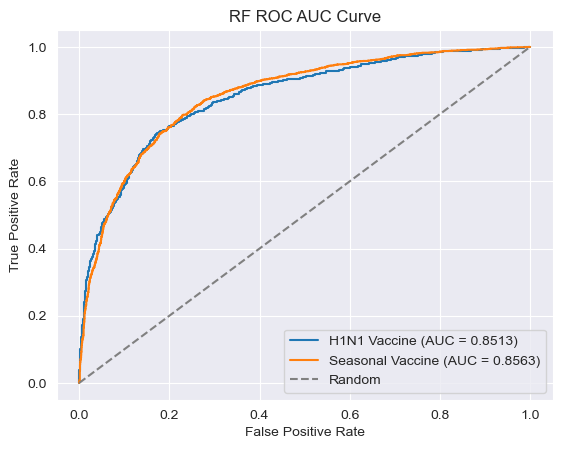

In [13]:
# Random Forest with parameters

y_h1n1 = train_labels[['respondent_id', 'h1n1_vaccine']]
train_features_undersampled, y_h1n1_undersampled = undersample_data(train_features, y_h1n1)

# Split into training and validation sets
X_train_h1n1, X_val_h1n1, y_train_h1n1, y_val_h1n1 = train_test_split(train_features_undersampled, y_h1n1_undersampled['h1n1_vaccine'], test_size=0.2, random_state=42)

# Train the model
tree_h1n1 = RandomForestClassifier(max_depth = 15,min_samples_leaf = 2,n_estimators = 300)
tree_h1n1.fit(X_train_h1n1, y_train_h1n1)

# Predict probabilities and compute ROC and AUC
y_h1n1_predict = tree_h1n1.predict_proba(X_val_h1n1)[:,1]
fpr1, tpr1, _ = roc_curve(y_val_h1n1, y_h1n1_predict)
auc1 = roc_auc_score(y_val_h1n1, y_h1n1_predict)

# 'seasonal_vaccine' training
y_seasonal = train_labels['seasonal_vaccine']
X_train_seasonal, X_val_seasonal, y_train_seasonal, y_val_seasonal = train_test_split(train_features, y_seasonal, test_size=0.2, random_state=42)

# Train the model
tree_seasonal = RandomForestClassifier(max_depth = 20,min_samples_leaf = 3,n_estimators = 300)
tree_seasonal.fit(X_train_seasonal, y_train_seasonal)

# Predict probabilities and compute ROC and AUC
y_seasonal_predict = tree_seasonal.predict_proba(X_val_seasonal)[:,1]
fpr2, tpr2, _ = roc_curve(y_val_seasonal, y_seasonal_predict)
auc2 = roc_auc_score(y_val_seasonal, y_seasonal_predict)

y_h1n1_pred = tree_h1n1.predict(X_val_h1n1)
accuracy_h1n1 = accuracy_score(y_val_h1n1, y_h1n1_pred)
print(f'H1N1 Vaccine Accuracy: {accuracy_h1n1:.4f}')
recall_h1n1 = recall_score(y_val_h1n1, y_h1n1_pred)
print(f'H1N1 Vaccine Recall: {recall_h1n1:.4f}')
f1_h1n1 = f1_score(y_val_h1n1, y_h1n1_pred)
print(f'H1N1 Vaccine F1 Score: {f1_h1n1:.4f}')

y_seasonal_pred = tree_seasonal.predict(X_val_seasonal)
accuracy_seasonal = accuracy_score(y_val_seasonal, y_seasonal_pred)
print(f'Seasonal Vaccine Accuracy: {accuracy_seasonal:.4f}')
recall_seasonal = recall_score(y_val_seasonal, y_seasonal_pred)
print(f'Seasonal Vaccine Recall: {recall_seasonal:.4f}')
f1_seasonal = f1_score(y_val_seasonal, y_seasonal_pred)
print(f'Seasonal Vaccine F1 Score: {f1_seasonal:.4f}')

# Draw the ROC curve
plt.figure()
plt.plot(fpr1, tpr1, label=f'H1N1 Vaccine (AUC = {auc1:.4f})')
plt.plot(fpr2, tpr2, label=f'Seasonal Vaccine (AUC = {auc2:.4f})')
plt.plot([0, 1], [0, 1], '--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RF ROC AUC Curve')
plt.legend(loc='lower right')
plt.show()


# Model Prediction
This part uses the random forest model to predict the test set data and save it to the csv file

In [14]:
X_test_all = new_test_data
y_h1n1_predict = tree_h1n1.predict_proba(X_test_all)[:,1]
y_seasonal_predict = tree_seasonal.predict_proba(X_test_all)[:,1]
results = pd.DataFrame({ 'respondent_id': test_data['respondent_id'],'h1n1_vaccine': y_h1n1_predict , 'seasonal_vaccine': y_seasonal_predict})
# Save as csv file
results.to_csv('result/predictions_RF_ALL_F_pyz.csv', index=False)

# Ablation Experiment
 In this section, we will conduct an Ablation experiment through which we can understand the impact of each feature group on the model's predictive performance. We will conduct experiments separately for `h1n1_vaccine` and `seasonal_vaccine`.

In [15]:
# Define an ablation experiment
def ablation_experiment_v2(feature_groups, train_features, train_labels, model,k):
    best_auc_h1n1 = 0
    best_auc_seasonal = 0
    best_h1n1_model = None
    best_seasonal_model = None

    # Create a figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    for i, (group_name, feature_group) in enumerate(feature_groups.items()):
        print(f'Performing ablation experiment by excluding {group_name}...')

        # Remove the feature group from training data
        features_to_remove = feature_group
        features_filtered = train_features.drop(features_to_remove, axis=1)

        # Initialize cross-validation
        skf = StratifiedKFold(n_splits=k, random_state=42, shuffle=True)

        for target_label, color in zip(['h1n1_vaccine', 'seasonal_vaccine'], ['b', 'r']):
            print(f'Training and evaluating model for {target_label}...')
            aucs = []
            accuracies = []
            precisions = []
            recalls = []
            f1s = []
            for train_index, val_index in skf.split(features_filtered, train_labels[target_label]):

                X_train, X_val = features_filtered.iloc[train_index], features_filtered.iloc[val_index]
                y_train, y_val = train_labels[target_label].iloc[train_index], train_labels[target_label].iloc[val_index]

                # Perform under-sampling if target_label is 'h1n1_vaccine'
                if target_label == 'h1n1_vaccine':
                    undersampler = RandomUnderSampler(random_state=42)
                    X_train, y_train = undersampler.fit_resample(X_train, y_train)


                # Train the model
                model.fit(X_train, y_train)

                # Predict probabilities
                probabilities = model.predict_proba(X_val)
                predictions = model.predict(X_val)

                accuracies.append(accuracy_score(y_val, predictions))
                precisions.append(precision_score(y_val, predictions))
                recalls.append(recall_score(y_val, predictions))
                f1s.append(f1_score(y_val, predictions))

                # Compute ROC curve and ROC area
                fpr, tpr, _ = roc_curve(y_val, probabilities[:, 1])
                roc_auc = auc(fpr, tpr)
                aucs.append(roc_auc)


            mean_auc = np.mean(aucs)
            mean_accuracy = np.mean(accuracies)
            mean_precision = np.mean(precisions)
            mean_recall = np.mean(recalls)
            mean_f1 = np.mean(f1s)
            print(f'Average ROC AUC score for {target_label}: {mean_auc:.3f}')
            print(f'Average accuracy for {target_label}: {mean_accuracy:.3f}')
            print(f'Average precision for {target_label}: {mean_precision:.3f}')
            print(f'Average recall for {target_label}: {mean_recall:.3f}')
            print(f'Average F1 score for {target_label}: {mean_f1:.3f}')

            # Update the best model if current model is better
            if target_label == 'h1n1_vaccine' and mean_auc > best_auc_h1n1:
                best_auc_h1n1 = mean_auc
                best_h1n1_model = model
            elif target_label == 'seasonal_vaccine' and mean_auc > best_auc_seasonal:
                best_auc_seasonal = mean_auc
                best_seasonal_model = model

            # Set the current subplot to be the active one
            plt.sca(axes[i])

            # Plot ROC curve
            plt.plot(fpr, tpr, color=color, lw=2, label=f'ROC curve for {target_label} (area = {roc_auc:.3f})')

        # Plot settings
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic (ROC) Curve\nExcluding {group_name}')
        plt.legend(loc="lower right")

    # Show the plot
    plt.tight_layout()  # Adjusts subplot params so that subplots are nicely fit in the figure.
    plt.show()

    return best_h1n1_model, best_seasonal_model


# Group features
In this section, we classify the features so that in the subsequent Ablation experiment, we can understand the impact of each feature group on the performance of the model.

In [16]:
# Respondents' personal backgrounds
personal_backgrounds = [
    'age_group',
    'education',
    'race',
    'sex',
    'income_poverty',
    'marital_status',
    'rent_or_own',
    'employment_status',
    'hhs_geo_region',
    'census_msa',
    'household_adults',
    'household_children',
    # 'employment_industry',
    # 'employment_occupation',
    'health_worker',
    'health_insurance',
    'chronic_med_condition',
    'child_under_6_months'
]

# Respondents' perceptions of vaccines
perceptions_of_vaccines = [
    'h1n1_concern',
    'h1n1_knowledge',
    'doctor_recc_h1n1',
    'doctor_recc_seasonal',
    'opinion_h1n1_vacc_effective',
    'opinion_h1n1_risk',
    'opinion_h1n1_sick_from_vacc',
    'opinion_seas_vacc_effective',
    'opinion_seas_risk',
    'opinion_seas_sick_from_vacc'
]

# Respondents' daily behaviors
daily_behaviors = [
    'behavioral_antiviral_meds',
    'behavioral_avoidance',
    'behavioral_face_mask',
    'behavioral_wash_hands',
    'behavioral_large_gatherings',
    'behavioral_outside_home',
    'behavioral_touch_face'
]

# One-hot encoded columns
onehot_columns = onehot_train_data.columns.tolist()

# Replace the one-hot encoded features in the original feature list with the encoded columns
personal_backgrounds = [col for col in personal_backgrounds if col not in cat_columns] + [col for col in onehot_columns if col.startswith(tuple(personal_backgrounds))]
perceptions_of_vaccines = [col for col in perceptions_of_vaccines if col not in cat_columns] + [col for col in onehot_columns if col.startswith(tuple(perceptions_of_vaccines))]
daily_behaviors = [col for col in daily_behaviors if col not in cat_columns] + [col for col in onehot_columns if col.startswith(tuple(daily_behaviors))]

feature_groups = {
    "Respondents' personal backgrounds": personal_backgrounds,
    "Respondents' perceptions of vaccines": perceptions_of_vaccines,
    "Respondents' daily behaviors": daily_behaviors
}

# Train Random Forest and Logistic Regression models
In this section, we will perform the following steps:
 1. **Train the random forest model**: We use the best parameters found by GridSearchCV to train the random forest model, and then pass the model and data into the Ablation we defined earlier experimental function. We will train two models, one to predict `h1n1_vaccine` and one to predict `seasonal_vaccine`.
 2. **Train the logistic regression model**: We use the best parameters found by GridSearchCV to train the logistic regression model, and then pass the model and data into the Ablation experiment function we defined earlier. We will train two models, one to predict `h1n1_vaccine` and one to predict `seasonal_vaccine`.

In this way, we can understand which model is more suitable for our data by comparing the performance of the two models in the Ablation experiment, and can better understand the impact of individual feature groups on the prediction results.

Performing ablation experiment by excluding Respondents' personal backgrounds...
Training and evaluating model for h1n1_vaccine...
Average ROC AUC score for h1n1_vaccine: 0.822
Average accuracy for h1n1_vaccine: 0.767
Average precision for h1n1_vaccine: 0.469
Average recall for h1n1_vaccine: 0.728
Average F1 score for h1n1_vaccine: 0.571
Training and evaluating model for seasonal_vaccine...
Average ROC AUC score for seasonal_vaccine: 0.825
Average accuracy for seasonal_vaccine: 0.753
Average precision for seasonal_vaccine: 0.742
Average recall for seasonal_vaccine: 0.720
Average F1 score for seasonal_vaccine: 0.731
Performing ablation experiment by excluding Respondents' perceptions of vaccines...
Training and evaluating model for h1n1_vaccine...
Average ROC AUC score for h1n1_vaccine: 0.733
Average accuracy for h1n1_vaccine: 0.655
Average precision for h1n1_vaccine: 0.348
Average recall for h1n1_vaccine: 0.710
Average F1 score for h1n1_vaccine: 0.467
Training and evaluating model for 

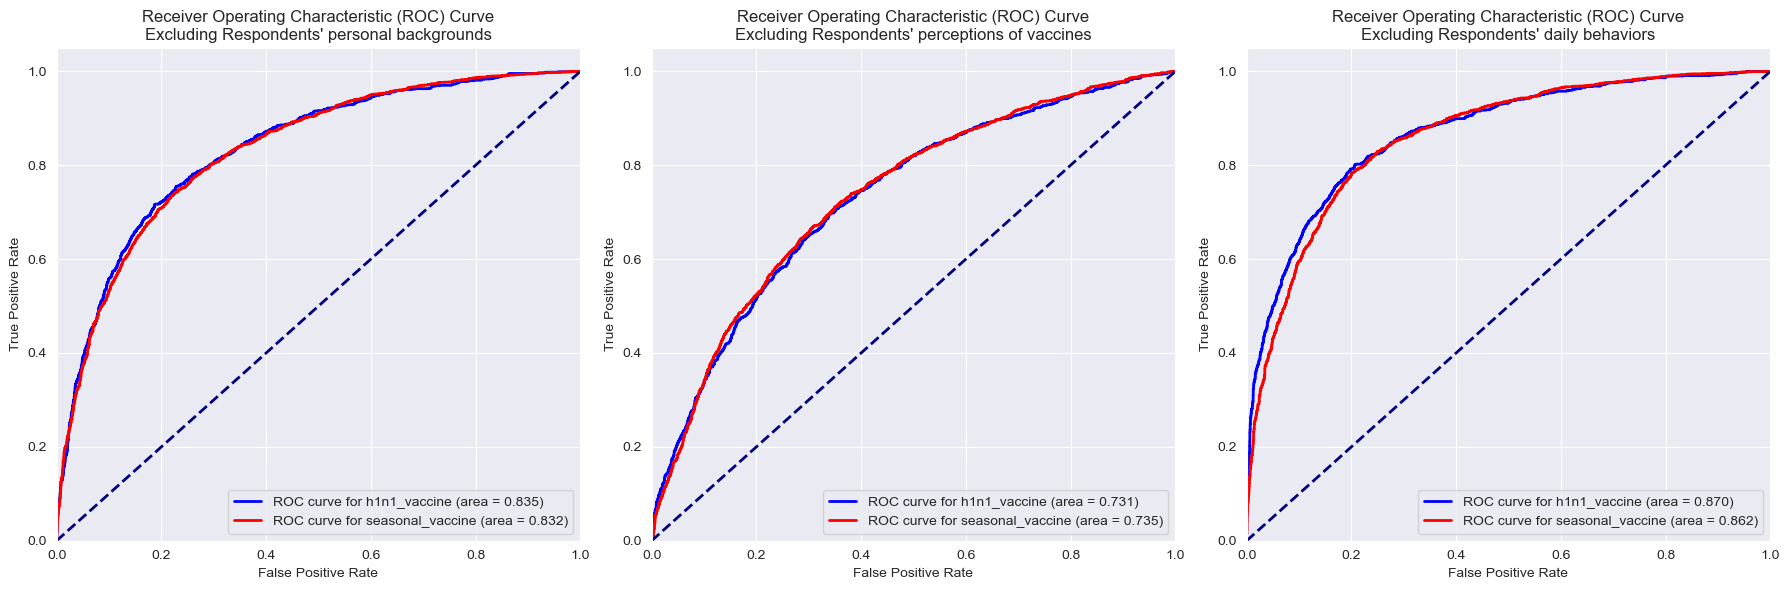

In [17]:
# Train Random Forest
RF_model = RandomForestClassifier(max_depth=15, min_samples_leaf=2, n_estimators=300, random_state=42)
best_h1n1_model, best_seasonal_model = ablation_experiment_v2(feature_groups, train_features, train_labels, RF_model, 5)

Performing ablation experiment by excluding Respondents' personal backgrounds...
Training and evaluating model for h1n1_vaccine...
Average ROC AUC score for h1n1_vaccine: 0.823
Average accuracy for h1n1_vaccine: 0.770
Average precision for h1n1_vaccine: 0.474
Average recall for h1n1_vaccine: 0.720
Average F1 score for h1n1_vaccine: 0.572
Training and evaluating model for seasonal_vaccine...
Average ROC AUC score for seasonal_vaccine: 0.821
Average accuracy for seasonal_vaccine: 0.749
Average precision for seasonal_vaccine: 0.744
Average recall for seasonal_vaccine: 0.703
Average F1 score for seasonal_vaccine: 0.723
Performing ablation experiment by excluding Respondents' perceptions of vaccines...
Training and evaluating model for h1n1_vaccine...
Average ROC AUC score for h1n1_vaccine: 0.733
Average accuracy for h1n1_vaccine: 0.660
Average precision for h1n1_vaccine: 0.350
Average recall for h1n1_vaccine: 0.695
Average F1 score for h1n1_vaccine: 0.465
Training and evaluating model for 

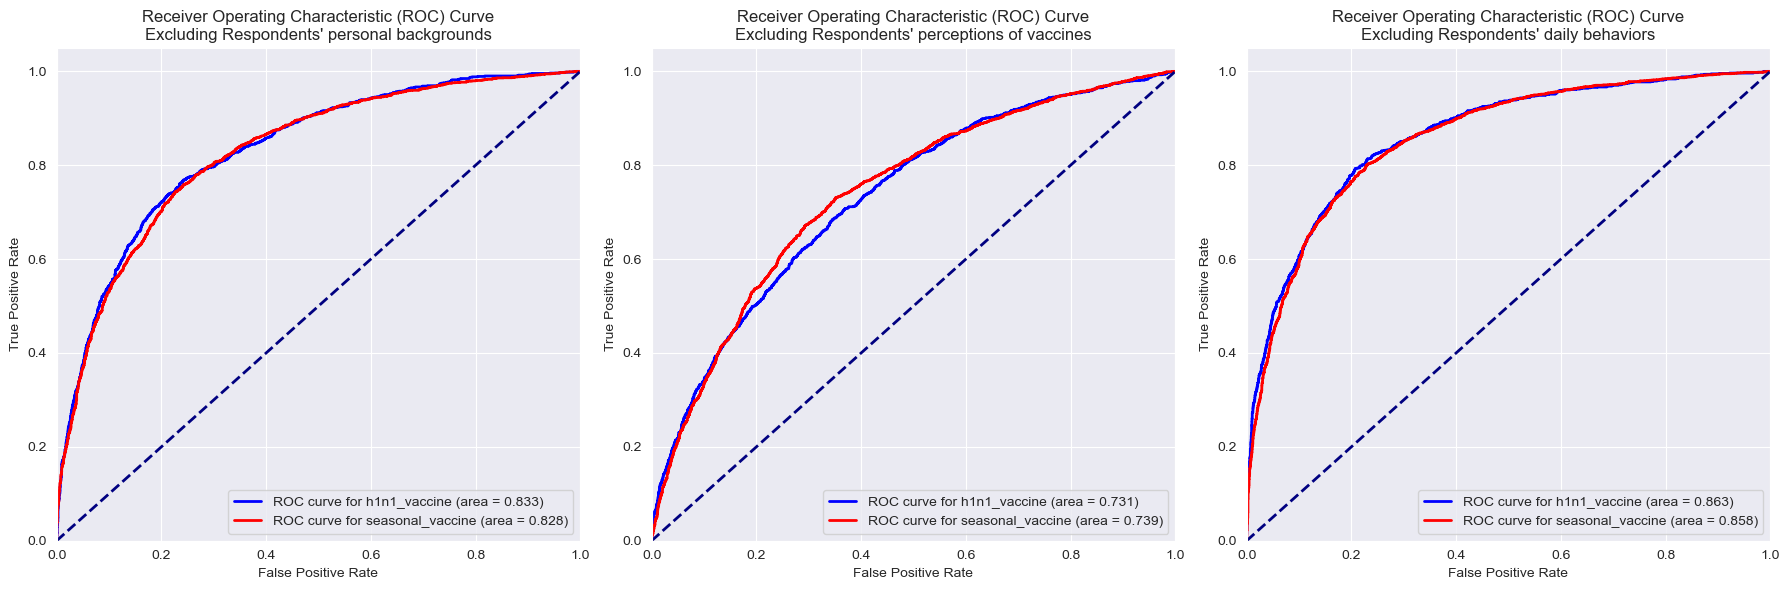

In [18]:
# Train Logistic Regression
logreg_model = LogisticRegression(C=1.0, penalty='l2', solver='liblinear')
best_h1n1_model2, best_seasonal_model2 = ablation_experiment_v2(feature_groups, train_features, train_labels, logreg_model, 5)

# Generate and save prediction results

In [19]:
X_test_AE = new_test_data.drop(daily_behaviors, axis =1)
y_h1n1_predict_AE = best_h1n1_model.predict_proba(X_test_AE)[:,1]
y_seasonal_predict_AE = best_seasonal_model.predict_proba(X_test_AE)[:,1]
results = pd.DataFrame({'respondent_id': test_data['respondent_id'], 'h1n1_vaccine': y_h1n1_predict_AE , 'seasonal_vaccine': y_seasonal_predict_AE})
# Output the result as csv file
results.to_csv('result/predictions_ablation_experiment_pyz.csv', index=False)